# Optimizing EKG Circuit

Created by Thomas Jagielski and Arwen Sadler

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Question:

For this project we were interested in modeling the EKG circuit we built in Introduction to Sensors, Instrumentation and Measurements (ISIM).  The question we addressed was, how does this circuit respond with changes in RC values?

###### Diagram of Circuit Modeled:

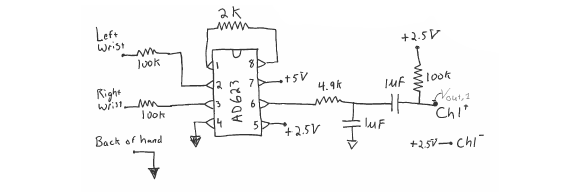

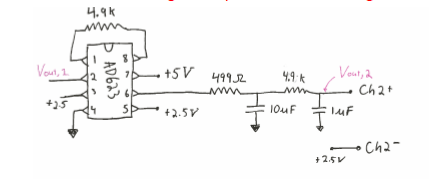

### Model 1:

Note: We model the input heart rate is a cosine wave.

Below we set the input signal frequency similar to the frequency of the average heart rate.  This data is taken from the Cleavlend Clinic, https://my.clevelandclinic.org/health/diagnostics/17402-pulse--heart-rate, which states the average heart rate of an adult to be 60 - 100 beats per minute.  Converted to frequency, in Hz, this is 1 Hz ({60 beats / 1 minute} * {1 minute / 60 seconds} = 1 beat per second => 1 Hz).

In [2]:
#Change the input signal frequnecy
input_freq = Params(
    f = 1
)

,values
f,1


We then initialize the first filter's parameters.

In [3]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,1.000000
vin,0.000000


We then define a function to make a system object with the input paramters.  This allows us to make system objects by creating new parameter objects. 

In [4]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    # Omega is eaual to angular frequency
    omega = 2 * np.pi * input_freq.f
    # Tau is equal to the RC Value
    tau = R * C
    # The cutoff frequnecy shows where the filters take effect
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [5]:
# Use params1 to make a system object
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


We plot the input signal on a chart using the system1 parameters.

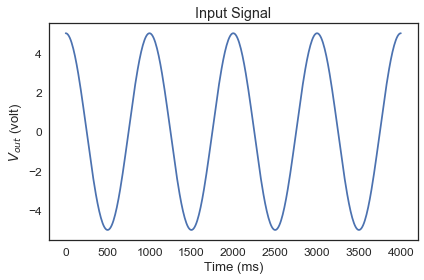

In [6]:
x = linspace(0, system1.t_end * 1000, 401)
v = system1.A * np.cos(2 * pi * (system1.f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

We define a slope function to express the change in voltage across the filter.  This models the effect of the filter based on RC values and the frequency of the input signal.  We run this function with the run_ode_solver.

In [7]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [8]:
# Run system1 through slope_func_init using the run_ode_sovler
results1, details1 = run_ode_solver(system1, 
                                    slope_func_init, 
                                    t_eval=system1.ts)

In [9]:
def plot_results(results):
    """Makes function to plot the results given in a DataFrame.
    
    results: DataFrame of the results of 
             run_ode_solver on a slope function
    
    returns: a plot of the results"""
    
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

We then set the parameters of the second filter and make a system of these values.

In [10]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.00 0.000000 0.01 4.346388 0.02 4.89...


In [11]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.1
cutoff,1.59155


We create a slope function that models a high pass filter.

In [12]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin1 = A * np.cos(2 * pi * f * t)
    
    #vin = interpolate(system.vin)
    
    dvindt = (vin1 - vout) / (R * C)
    
    dvoutdt = dvindt - ((vout) / (R * C))
    
    return dvoutdt

We create a slope function that models a low pass filter.

In [13]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

The second filter is a high pass filter, and thus, we are able to use the run_ode_solver function with the second set of parameters and the high pass filter slope function.

In [14]:
results2, details2 = run_ode_solver(system2, 
                                    slope_func_high_pass, 
                                    t_eval=system2.ts)

We then set the third filter's parameters and use them to make a system for the third filter.

In [15]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.00 0.000000 0.01 0.452860 0.02 0.82...


In [16]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.00499
cutoff,31.8948


The third and fourth filters used are low pass filters.  Thus, we use the same process with the low pass filter slope function for these filters.

In [17]:
results3, details3 = run_ode_solver(system3, 
                                    slope_func_low_pass, 
                                    t_eval=system3.ts)

We set the fourth filter's parameters and then use them to make a system for the fourth filter.

In [18]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.00 0.000000 0.01 0.257302 0.02 0.63...


In [19]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


In [20]:
results4, details4 = run_ode_solver(system4, 
                                    slope_func_low_pass, 
                                    t_eval=system4.ts)

### Results:

We plot the results of all of the filters on the same chart.

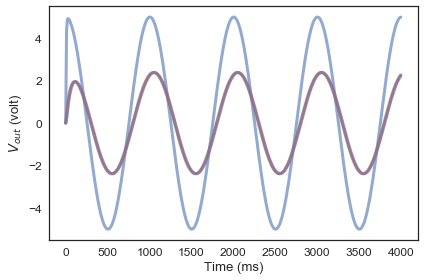

In [21]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

We then plot the input signal and the output signal to compare the attenuation through the circuit.

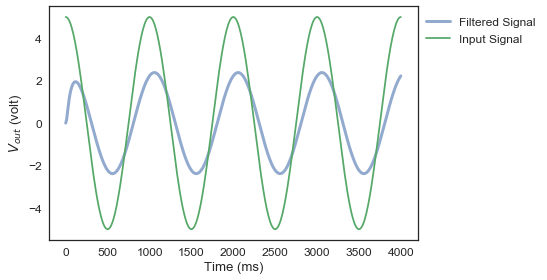

In [22]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], 
           loc='upper right', bbox_to_anchor=(1.35, 1))

### Model 2:

We define a function that determines the amplification of the AD623 integrated circuit used.  This value is expressed through the equation

In [23]:
def amp(R):
    """Makes function to determine the gain of the AD623 amplifier.
    
    R: The reststance value across pins 1 and 8 on this chip
    
    returns: The gain of the amplifier
    """
    G = 1 + (100e3/R)
    return G

We find the gain for both amplifers.  G1 expresses the gain of the first chip, and G2 expresses the gain of the second chip.

In [24]:
G1 = amp(2e3)
G2 = amp(4.9e3);

We set the parameters of all the resisters and capacitors in the circuit, which we then use in a function that runs the entire circuit simulation.

In [25]:
run_sim_system = System(R1 = 4.9e3, # ohm
                        C1 = 1e-6,  # farad 
                        A = 5 * G1, # volt
                        f = input_freq.f,   # Hz 
                        vin = 0, 
                        R2 = 100e3,   # ohm
                        C2 = 1e-6,  # farad
                        R3 = 499,   # ohm
                        C3 = 10e-6,  # farad
                        R4 = 4.9e3,   # ohm
                        C4 = 1e-6  # farad
                        )

,values
R1,4900.000000
C1,0.000001
A,255.000000
f,1.000000
vin,0.000000
R2,100000.000000
C2,0.000001
R3,499.000000
C3,0.000010
R4,4900.000000


We define a function that runs through the entire simiulation using the fuctions defined in Model 1 and the paramters defined above.

In [26]:
def run_sim(input_freq, make_system, 
            slope_func_init, slope_func_high_pass, 
            slope_func_low_pass, G1, G2, system):
    
    """Define a function that runs the enitre circuit simulation
    
    inputs
        input_freq: the input signal frequency
        make_system: function that takes parameters and returns a system
        slope_func_init: used to model the first filter
        slope_func_high_pass: used to model high pass filters
        slope_func_low_pass: used to model low pass filters
        G1: the gain of the first amplifier
        G2: the gain of the second amplifier
        system: the parameters of the circuit
    
    returns
        results5: the output of the first filter
        results6: the output of the second filter
        results7: the output of the thrid filter
        results8: the output of the fourth filter
        ratio: the ratio of input signal amplitude to ourput signal amplitude
    """
    
    params5 = Params(
    R = system.R1,   
    C = system.C1,  
    A = system.A,      
    f = system.f,   
    vin = system.vin
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, 
                                        slope_func_init, 
                                        t_eval=system5.ts)
    
    params6 = Params(
    R = system.R2,
    C = system.C2,
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, 
                                        slope_func_high_pass, 
                                        t_eval=system6.ts)
    
    params7 = Params(
    R = system.R3,
    C = system.C3,
    vin = results6.V_out * G2
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, 
                                        slope_func_low_pass, 
                                        t_eval=system7.ts)
    
    params8 = Params(
    R = system.R4,
    C = system.C4,
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, 
                                        slope_func_low_pass, 
                                        t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, 
                 results6=results6, 
                 result7=results7, 
                 results8=results8, 
                 ratio=ratio)

We set the input frequency to 50 Hz, to test the circuit at high frequencies.  We do this to confirm that each of the filters are working as there is an apparent difference in the outputs of each filter.

In [27]:
input_freq.f = 50

In [28]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system)

### Results 2:

The simualtion is run with an input frequency of 50 Hz to show that each of the filters are working.  We can see that much of the high frequency is filtered out.

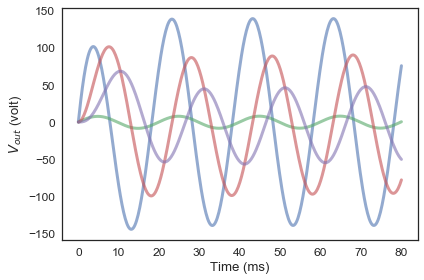

In [29]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [ ]:
sweep = SweepSeries()
for f in linspace(1, 100, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system).ratio
    sweep[f] = state;

In [ ]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')

print(sweep)

In [ ]:
from pandas import read_csv
data = read_csv("Bode Plot Data Two Channel Adjusted.csv")
data.columns = ["Frequency", "Channel1", "Channel2"]
print(data)

In [ ]:
def plot_data(data):
    f = (data.Frequency)
    a = (data.Channel2)
       
    plot(f, a)
    decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Collected Data',
             legend=False)

In [ ]:
plot_data(data)

In [ ]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             title='Bode Plot Simulated VS Collected Data')
plot_data(data)

In [ ]:
input_freq.f = 1

In [ ]:
example_system = make_system(params1)

In [ ]:
example_results1, exmpale_details1 = run_ode_solver(example_system, 
                                                    slope_func_high_pass, 
                                                    t_eval=example_system.ts)

In [ ]:
example_results2, exmaple_details2 = run_ode_solver(example_system, 
                                                    slope_func_init, 
                                                    t_eval=example_system.ts)

In [ ]:
plot_results(example_results1)
plot_results(example_results2)

In [ ]:
run_sim_system2 = System(R1 = 4.9e3, # ohm
                          C1 = 1e-6,  # farad 
                          A = 5 * G1, # volt
                          f = input_freq.f,   # Hz 
                          vin = 0, 
                          R2 = 100e3,   # ohm
                          C2 = 1e-6,  # farad
                          R3 = 499,   # ohm
                          C3 = 10e-6,  # farad
                          R4 = 4.9e3,   # ohm
                          C4 = 1e-6  # farad
                          )

In [ ]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system2)

In [ ]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [ ]:
sweep2 = SweepSeries()
for f in linspace(1, 50, 50):
    print(f)
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system2).ratio
    sweep2[f] = state;

In [ ]:
plot(sweep2)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')